In [24]:
import numpy as np
from numpy.linalg import inv

In [25]:
x_observations = np.array([4000, 4260, 4550, 4860, 5110])
v_observations = np.array([280, 282, 285, 286, 290])

z = np.c_[x_observations, v_observations]

# Initial Conditions
a = 2  # Acceleration
v = 280
t = 1  # Difference in time

# Process / Estimation Errors
error_est_x = 20
error_est_v = 5

# Observation Errors
error_obs_x = 25  # Uncertainty in the measurement
error_obs_v = 6

In [26]:
z

array([[4000,  280],
       [4260,  282],
       [4550,  285],
       [4860,  286],
       [5110,  290]])

In [27]:
def prediction2d(x, v, t, a):
    A = np.array([[1, t],
                  [0, 1]])
    X = np.array([[x],
                  [v]])
    B = np.array([[0.5 * t ** 2],
                  [t]])
    X_prime = A.dot(X) + B.dot(a)
    return X_prime


def covariance2d(sigma1, sigma2):
    cov1_2 = sigma1 * sigma2
    cov2_1 = sigma2 * sigma1
    cov_matrix = np.array([[sigma1 ** 2, cov1_2],
                           [cov2_1, sigma2 ** 2]])
    return np.diag(np.diag(cov_matrix))

In [28]:
# Initial Estimation Covariance Matrix
P = covariance2d(error_est_x, error_est_v)
A = np.array([[1, t],
              [0, 1]])

# Initial State Matrix
X = np.array([[z[0][0]],
              [v]])
n = len(z[0])

In [29]:

for data in z[1:]:
    X = prediction2d(X[0][0], X[1][0], t, a)
    # To simplify the problem, professor
    # set off-diagonal terms to 0.
    P = np.diag(np.diag(A.dot(P).dot(A.T)))

    # Calculating the Kalman Gain
    H = np.identity(n)
    R = covariance2d(error_obs_x, error_obs_v)
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H).dot(inv(S))

    # Reshape the new data into the measurement space.
    Y = H.dot(data).reshape(n, -1)

    # Update the State Matrix
    # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
    X = X + K.dot(Y - H.dot(X))

    # Update Process Covariance Matrix
    P = (np.identity(len(K)) - K.dot(H)).dot(P)

print("Kalman Filter State Matrix:\n", X)

Kalman Filter State Matrix:
 [[5127.05898493]
 [ 288.55147059]]


https://thekalmanfilter.com/kalman-filter-python-example/

In [30]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [31]:
def getMeasurement(updateNumber):
    if updateNumber == 1:
        getMeasurement.currentPosition = 0
        getMeasurement.currentVelocity = 60 # m/s
    dt = 0.1
    w = 8 * np.random.randn(1)
    v = 8 * np.random.randn(1)
    z = getMeasurement.currentPosition + getMeasurement.currentVelocity*dt + v
    getMeasurement.currentPosition = z - v
    getMeasurement.currentVelocity = 60 + w
    return [z, getMeasurement.currentPosition, getMeasurement.currentVelocity]

In [32]:
getMeasurement(1)


[array([-7.16016131]), array([6.]), array([61.75572695])]

In [33]:
def filter(z, updateNumber):
    dt = 0.1
    # Initialize State
    if updateNumber == 1:
        filter.x = np.array([[0],
                            [20]])
        filter.P = np.array([[5, 0],
                                 [0, 5]])
        filter.A = np.array([[1, dt],
                             [0, 1]])
        filter.H = np.array([[1, 0]])
        filter.HT = np.array([[1],
                              [0]])
        filter.R = 10
        filter.Q = np.array([[1, 0],
                             [0, 3]])
    # Predict State Forward
    x_p = filter.A.dot(filter.x)
    
    
    # Predict Covariance Forward
    P_p = filter.A.dot(filter.P).dot(filter.A.T) + filter.Q   #nxn
    # Compute Kalman Gain
    S = filter.H.dot(P_p).dot(filter.HT) + filter.R # mxm
    K = P_p.dot(filter.HT)*(inv(S)) #nxm
    # Estimate State
    residual = z - filter.H.dot(x_p) # mx1 
    filter.x = x_p + K*residual #nx1
    # Estimate Covariance
    filter.P = P_p - K.dot(filter.H).dot(P_p)
    return [filter.x[0], filter.x[1], filter.P];

def testFilter():
    dt = 0.1
    t = np.linspace(0, 10, num=300)
    numOfMeasurements = len(t)
    measTime = []
    measPos = []
    measDifPos = []
    estDifPos = []
    estPos = []
    estVel = []
    posBound3Sigma = []
    for k in range(1,numOfMeasurements):
        z = getMeasurement(k)
        # Call Filter and return new State
        f = filter(z[0], k)
        # Save off that state so that it could be plotted
        measTime.append(k)
        measPos.append(z[0])
        measDifPos.append(z[0]-z[1])
        estDifPos.append(f[0]-z[1])
        estPos.append(f[0])
        estVel.append(f[1])
        posVar = f[2]
        posBound3Sigma.append(3*np.sqrt(posVar[0][0]))
    return [measTime, measPos, estPos, estVel, measDifPos, estDifPos, posBound3Sigma];

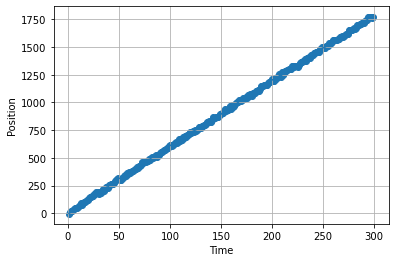

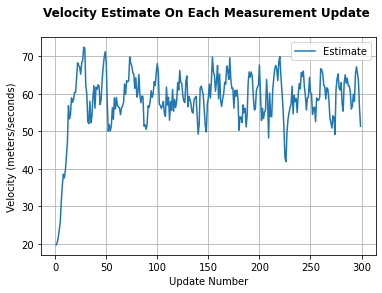

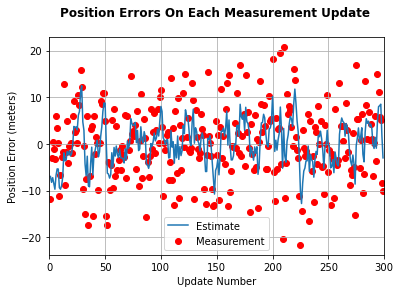

In [34]:
t = testFilter()
plot1 = plt.figure(1)
plt.scatter(t[0], t[1])
plt.plot(t[0], t[2])
plt.ylabel('Position')
plt.xlabel('Time')
plt.grid(True)
plot2 = plt.figure(2)
plt.plot(t[0], t[3])
plt.ylabel('Velocity (meters/seconds)')
plt.xlabel('Update Number')
plt.title('Velocity Estimate On Each Measurement Update \n', fontweight="bold")
plt.legend(['Estimate'])
plt.grid(True)
plot3 = plt.figure(3)
plt.scatter(t[0], t[4], color = 'red')
plt.plot(t[0], t[5])
plt.legend(['Estimate', 'Measurement'])
plt.title('Position Errors On Each Measurement Update \n', fontweight="bold")
#plt.plot(t[0], t[6])
plt.ylabel('Position Error (meters)')
plt.xlabel('Update Number')
plt.grid(True)
plt.xlim([0, 300])
plt.show()